# Kaggle Titanic Challenge

https://www.kaggle.com/c/titanic

In [23]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
train_df = pd.read_csv("data/train.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
target = train_df['Survived']
print(target.shape)

(891,)


## Feature Engineering

In [4]:
# Cabin Feature
def cabin_f(row):
    value = row['Cabin']
    if type(value) == float:
        return 0
    else:
        return value[0] > 'A' and value[0] > 'C'

In [5]:
def to_features(df, training_data: bool):
    drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    
    # TODO: Extract famous persons from WikiData

    if training_data == True:
        drop_columns.append('Survived')
    result = df.drop(drop_columns, axis=1)
    
    result['Pclass'] = result['Pclass'].astype(str)
    
#     result['Cabin'] = result.apply(cabin_f, axis=1)    
    
    # NA    
    result['Embarked'] = result['Embarked'].fillna(method='ffill')

    # Fare
    result['Fare'] = result['Fare'] >= 100
    # Age
    result['Age'] = result['Age'].fillna(method='ffill')
    result['Age_2'] = result.apply(lambda row: row['Age'] > 20 and row['Age'] <= 40, axis = 1)
    result['Age_3'] = result['Age'] > 40 
    result['Age'] = result['Age'] <= 20
    
    # Sib Sp
    result['SibSp'] = result['SibSp'] > 3
    
    result['Parch'] = result['Parch'] > 2

    # Fare
    # compute 'Fare' feature based on class name
#     result['Fare'] = result['Fare'].fillna(method='ffill')
    
    # DictVectorizer
    data = result.to_dict('records')
    vec = DictVectorizer(sparse=False, dtype=int)
    result = pd.DataFrame(vec.fit_transform(data), columns=vec.get_feature_names())

    return result

In [6]:
features = to_features(train_df, True)
print(features.shape)
print(features.columns)
print(features)

(891, 14)
Index(['Age', 'Age_2', 'Age_3', 'Embarked=C', 'Embarked=Q', 'Embarked=S',
       'Fare', 'Parch', 'Pclass=1', 'Pclass=2', 'Pclass=3', 'Sex=female',
       'Sex=male', 'SibSp'],
      dtype='object')
     Age  Age_2  Age_3  Embarked=C  Embarked=Q  Embarked=S  Fare  Parch  \
0      0      1      0           0           0           1     0      0   
1      0      1      0           1           0           0     0      0   
2      0      1      0           0           0           1     0      0   
3      0      1      0           0           0           1     0      0   
4      0      1      0           0           0           1     0      0   
..   ...    ...    ...         ...         ...         ...   ...    ...   
886    0      1      0           0           0           1     0      0   
887    1      0      0           0           0           1     0      0   
888    1      0      0           0           0           1     0      0   
889    0      1      0           1       

In [7]:
features.isnull().any()

Age           False
Age_2         False
Age_3         False
Embarked=C    False
Embarked=Q    False
Embarked=S    False
Fare          False
Parch         False
Pclass=1      False
Pclass=2      False
Pclass=3      False
Sex=female    False
Sex=male      False
SibSp         False
dtype: bool

In [8]:
features

,Age,Age_2,Age_3,Embarked=C,Embarked=Q,Embarked=S,Fare,Parch,Pclass=1,Pclass=2,Pclass=3,Sex=female,Sex=male,SibSp
0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
1,0,1,0,1,0,0,0,0,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,1,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,1,0,0,0,1,0,0,1,0
887,1,0,0,0,0,1,0,0,1,0,0,1,0,0
888,1,0,0,0,0,1,0,0,0,0,1,1,0,0
889,0,1,0,1,0,0,0,0,1,0,0,0,1,0


## Train Model

### Random Forest Classifier with Grid Search CV

In [9]:
grid = GridSearchCV(RandomForestClassifier(), cv=5,
                    param_grid = {'max_depth': [2, 4, 8, 16, 32],
                                  'n_estimators': [30, 50, 100, 150, 200, 300]})
grid.fit(features, target)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [10]:
grid.best_params_

{'max_depth': 4, 'n_estimators': 30}

In [11]:
grid.best_score_

0.8013558470905782

In [12]:
# model = RandomForestClassifier(max_depth = grid.best_params_['max_depth'], 
#                                n_estimators = grid.best_params_['n_estimators'])

model = RandomForestClassifier(max_depth = 8, 
                               n_estimators = 100)

model.fit(features, target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
predicted = model.predict(features)
(predicted == target).mean()

0.8181818181818182

In [14]:
accuracy_score(predicted, target)

0.8181818181818182

## Submission

In [15]:
test_df = pd.read_csv("data/test.csv")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [16]:
test_features = to_features(test_df, False)
# TODO: Fix it automatically
# test_features['Cabin=T'] = 0
test_features

,Age,Age_2,Age_3,Embarked=C,Embarked=Q,Embarked=S,Fare,Parch,Pclass=1,Pclass=2,Pclass=3,Sex=female,Sex=male,SibSp
0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
1,0,0,1,0,0,1,0,0,0,0,1,1,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,1,0,1,0
4,0,1,0,0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,0,0,0,1,0,0,0,0,1,0,1,0
414,0,1,0,1,0,0,1,0,1,0,0,1,0,0
415,0,1,0,0,0,1,0,0,0,0,1,0,1,0
416,0,1,0,0,0,1,0,0,0,0,1,0,1,0


In [17]:
predicted = model.predict(test_features)

In [18]:
output = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predicted})
output.to_csv('my_submission-7.csv', index=False)

## Data Visualization

In [49]:
data = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Age'], axis=1)

In [50]:
def cabin_f(row):
    cabin = row['Cabin']
    if type(cabin) == float:
        return 'NA'
    else:
        return cabin[0]
data['Cabin'] = data.apply(cabin_f, axis=1)

In [53]:
data

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Embarked
0,0,3,male,1,0,NA,S
1,1,1,female,1,0,C,C
2,1,3,female,0,0,NA,S
3,1,1,female,1,0,C,S
4,0,3,male,0,0,NA,S
...,...,...,...,...,...,...,...
886,0,2,male,0,0,NA,S
887,1,1,female,0,0,B,S
888,0,3,female,1,2,NA,S
889,1,1,male,0,0,C,C


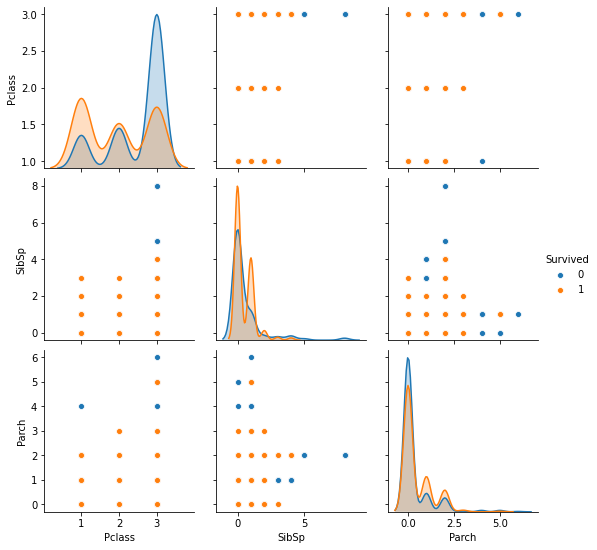

In [52]:
sns.pairplot(data, hue='Survived')

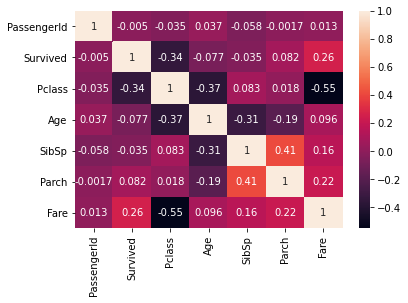

In [24]:
sns.heatmap(train_df.corr(),annot= True)